# DC2 Coadd Run1.1p GCR access

This tutorial will illustrate how to access the coadd catalog through the GCR, apply some filters and cuts on the data, and select a useful sample of objects.

In [2]:
import sys
sys.path.insert(0, '/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages')
import GCRCatalogs
from GCR import GCRQuery
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Accessing the coadd catalog with the GCR


- Explain the idea of native quantities and DPDD compliant fields
- Show how to access native fields if necessary
- Quickly go through the most important fields
- Explain how to return data as pandas DF


- Explain how the data is structured in terms of tract/patches
- Show how to load catalog
- Query the tracts and patches
- Apply native filters (needs knowledge of how the data is actually stored) and native iterators

In [3]:
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [3]:
sorted(catalog.list_all_quantities())

['I_flag',
 'I_flag_g',
 'I_flag_i',
 'I_flag_r',
 'I_flag_u',
 'I_flag_y',
 'I_flag_z',
 'Ixx',
 'IxxPSF',
 'IxxPSF_g',
 'IxxPSF_i',
 'IxxPSF_r',
 'IxxPSF_u',
 'IxxPSF_y',
 'IxxPSF_z',
 'Ixx_g',
 'Ixx_i',
 'Ixx_r',
 'Ixx_u',
 'Ixx_y',
 'Ixx_z',
 'Ixy',
 'IxyPSF',
 'IxyPSF_g',
 'IxyPSF_i',
 'IxyPSF_r',
 'IxyPSF_u',
 'IxyPSF_y',
 'IxyPSF_z',
 'Ixy_g',
 'Ixy_i',
 'Ixy_r',
 'Ixy_u',
 'Ixy_y',
 'Ixy_z',
 'Iyy',
 'IyyPSF',
 'IyyPSF_g',
 'IyyPSF_i',
 'IyyPSF_r',
 'IyyPSF_u',
 'IyyPSF_y',
 'IyyPSF_z',
 'Iyy_g',
 'Iyy_i',
 'Iyy_r',
 'Iyy_u',
 'Iyy_y',
 'Iyy_z',
 'blendedness',
 'clean',
 'dec',
 'extendedness',
 'good',
 'mag_g',
 'mag_g_cModel',
 'mag_i',
 'mag_i_cModel',
 'mag_r',
 'mag_r_cModel',
 'mag_u',
 'mag_u_cModel',
 'mag_y',
 'mag_y_cModel',
 'mag_z',
 'mag_z_cModel',
 'magerr_g',
 'magerr_g_cModel',
 'magerr_i',
 'magerr_i_cModel',
 'magerr_r',
 'magerr_r_cModel',
 'magerr_u',
 'magerr_u_cModel',
 'magerr_y',
 'magerr_y_cModel',
 'magerr_z',
 'magerr_z_cModel',
 'objectId',
 'paren

In [4]:
sorted(catalog.list_all_native_quantities())

['base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_flux',
 'base_Blendedness_abs_flux_child',
 'base_Blendedness_abs_flux_parent',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_xy',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_flag',
 'base_Blendedness_flag_noCentroid',
 'base_Blendedness_flag_noShape',
 'base_Blendedness_old',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_flux',
 'base_Blendedness_raw_flux_child',
 'base_Blendedness_raw_flux_parent',
 'base_Blendedness_raw_parent_xx',
 'base_Blendedness_raw_parent_xy',
 'base_Blendedness_raw_parent_yy',
 'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_flux',
 'base_CircularApertureFlux_12_0_fluxSigma',
 'base_CircularApertureFlux_17_0_flag',
 'base_CircularApertureFlux_17_0_fl

<img src="https://hsc-release.mtk.nao.ac.jp/rsrc/wide_coverage/W-XMMLSS_g_area.png">

In [21]:
catalog.available_tracts_and_patches[:5]

[{'patch': '0,1', 'tract': 4430},
 {'patch': '0,2', 'tract': 4430},
 {'patch': '0,3', 'tract': 4430},
 {'patch': '0,4', 'tract': 4430},
 {'patch': '0,5', 'tract': 4430}]

In [19]:
%timeit qt = catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==4430, 'tract')])

100 loops, best of 3: 17.2 ms per loop


In [20]:
%timeit qt = catalog.get_quantities(['ra', 'dec'])

The slowest run took 342.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 747 ms per loop


- Return data as dictionary, create pandas dataframe
- Return iterator

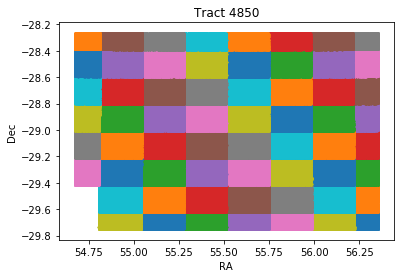

In [26]:
tract_number = 4850
for d in catalog.get_quantities(['ra', 'dec'], native_filters=[(lambda x: x==tract_number, 'tract')], return_iterator=True):
    plt.scatter(d['ra'], d['dec'], s=2);
plt.xlabel('RA');
plt.ylabel('Dec');
plt.title('Tract {}'.format(tract_number));

## Selection and filtering procedure
- Explain how to apply cuts with the GCR
- Show the effect of the `good` cut
- Show people how to select a sample of objects using the HSC `lensing` flag

## Example of filtering: Star/galaxy separation

For now, we have `extendedness == base_ClassificationExtendedness_value` as a tool for star/galaxy classification. An object is considered extended if the the difference between the `PSF` magnitude and the `CModel` magnitude is beyond certain threshold (0.0164). To know more about this see [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf) section 4.9.10

In [ ]:
star_cuts = [
    GCRQuery((False, 'extendedness'))
]
quantities = ['mag_g_cModel','mag_r_cModel','mag_i_cModel']
d = catalog.get_quantities(quantities, 
                           filters=star_cuts, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

So now, we are selected what we think are stars. Let's take a look at the colors of these objects

In [ ]:
plt.hist2d(plt.hist2d(d['g_mag_CModel']-d['r_mag_CModel'],d['r_mag_CModel']-d['i_mag_CModel'],bins=100,range=[(-1,2),(-1,2)]);
plt.xlabel('$g-r$')
plt.ylabel('$r-i$'))

* Compare with the reference catalog or just show the plot with the comparison?

## Example of filtering: Lensing cuts

In [42]:
catalog.add_quantity_modifier('HSM_res', 
                              'ext_shapeHSM_HsmShapeRegauss_resolution', 
                              overwrite=True)
catalog.add_quantity_modifier('HSM_ell', 
                              (np.hypot, 'ext_shapeHSM_HsmShapeRegauss_e1', 'ext_shapeHSM_HsmShapeRegauss_e2'), 
                              overwrite=True)

lensing_cuts = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('mag_i_cModel < 24.5'), # FIXME: Doesnt have exinction correction
    GCRQuery('blendedness < 10**(-0.375)'),
]

In [43]:
tract_number = 4850
quantities = ['mag_i_cModel']
d = catalog.get_quantities(quantities, 
                           filters=lensing_cuts, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


## Galaxy size and magnitudes compared to HSC 
- Mention the different types of size and magnitude measurments
- Comparison to HSC dataset

## Challenge: Galaxy counts-in-cells

Blending affects the accuracy of centroid and flux measurements. It can potentially generate a systematic effect in different measurements (for example 2-point statistics). 

The stack, returns a very useful value to check (partially) for the presence of these kind of systematics, which is the `blendedness` parameter (more details on Section 4.9.11 of [Bosch et al. 2017](https://arxiv.org/pdf/1705.06766.pdf)

* Q: Why partially?


A very simple tool to measure the different statistical moments of galaxies is Counts-in-cells (CiC) [Peebles et al. 1980](https://press.princeton.edu/titles/724.html). Here, we are going to use a simplified version of CiC to check the possible systematic effects due to differences in the `blendedness` measurements.

In [1]:
from cic import cic_analysis

In [2]:
import healpy as hp

In [ ]:
# Let's use almost the same cuts as in the WL sample
cic_cuts_nb = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness < 10**(-0.375)'),
]

cic_cuts_b = [
    ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
    ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
    GCRQuery('good'), 
    GCRQuery('snr_i_cModel >= 10'), # (from this and below) cut on object properties
    GCRQuery('HSM_res >= 0.3'),
    GCRQuery('HSM_ell < 2.0'),
    GCRQuery('ext_shapeHSM_HsmShapeRegauss_sigma <= 0.4'),
    GCRQuery('blendedness > 10**(-0.375)'),
]

quantities = ['ra','dec']
d_nb = catalog.get_quantities(quantities, 
                           filters=cic_cuts_nb, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])
d_b = catalog.get_quantities(quantities, 
                           filters=cic_cuts_b, 
                           native_filters=[(lambda x: x==tract_number, 'tract')])

sigma_b, sigma_err_b, skw_b, skw_err_b, kurtosis_b, kurtosis_err_b, pixel_scale = cic_analysis(d_b)
sigma_nb, sigma_err_nb, skw_nb, skw_err_nb, kurtosis_nb, kurtosis_err_nb, _  = cic_analysis(d_nb)
#TODO: Include CiC with shapes?

In [ ]:
plt.errorbar(pixel_scale, sigma_b, sigma_err_b, fmt='o', linestyle='none', label='High blendedness')
plt.errorbar(pixel_scale, sigma_nb, sigma_err_nb, fmt='x', linestyle='none', label='Low blendedness')
plt.legend()
plt.xlabel('Pixel scale [deg]')
plt.ylabel(r'$\sigma$')

## Challenge: Check if PSF residuals are within requirements

- First explain how the DM stack models stars and PSF
- How to select a sample of good looking stars
- compute rho statistics in stile

In [5]:
catalog = GCRCatalogs.load_catalog('dc2_coadd_run1.1p')

In [6]:
#TODO: A few words about PSF modeling

In [4]:
# Adds modifiers to compute stars size and ellipticity
g1_modif = lambda ixx,iyy,ixy: (ixx-iyy)/(ixx+iyy)
g2_modif = lambda ixx,iyy,ixy:  2.*ixy/(ixx+iyy)
sigma_modif = lambda ixx,iyy,ixy: (ixx*iyy - ixy**2)**0.25

catalog.add_modifier_on_derived_quantities('g1', g1_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_modifier_on_derived_quantities('g2', g2_modif, 'Ixx', 'Iyy', 'Ixy')
catalog.add_modifier_on_derived_quantities('sigma', sigma_modif, 'Ixx', 'Iyy', 'Ixy')

catalog.add_modifier_on_derived_quantities('psf_g1', g1_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_g2', g2_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')
catalog.add_modifier_on_derived_quantities('psf_sigma', sigma_modif, 'IxxPSF', 'IyyPSF', 'IxyPSF')

In [103]:
# Extracting data selecting only point sources
data = catalog.get_quantities(['ra', 'dec', 'mag_i', 'i_SNR', 'psf_fwhm_i',
                               'g1', 'g2', 'sigma',
                               'psf_g1', 'psf_g2', 'psf_sigma'], 
                               # native_filters=[(lambda x: x==4850, 'tract')],
                                filters=[GCRQuery('good'), 
                                         GCRQuery('clean'), 
                                        ~GCRQuery('I_flag'),
                                        ~GCRQuery('base_SdssShape_flag_badCentroid'),
                                         GCRQuery('extendedness == 0'),
                                        ~GCRQuery((np.isnan, 'mag_i_cModel')), # (from this and below) remove nan entries
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_resolution')),
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e1')),
                                        ~GCRQuery((np.isnan, 'ext_shapeHSM_HsmShapeRegauss_e2')),
                                         GCRQuery('blendedness < 10**(-0.375)'),
                                         GCRQuery('mag_i < 21')])

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: invalid value encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/GCRCatalogs/dc2_coadd.py:164: RuntimeWarning: divide by zero encountered in log10
  lambda x: -2.5 * np.log10(x) + 27.0,


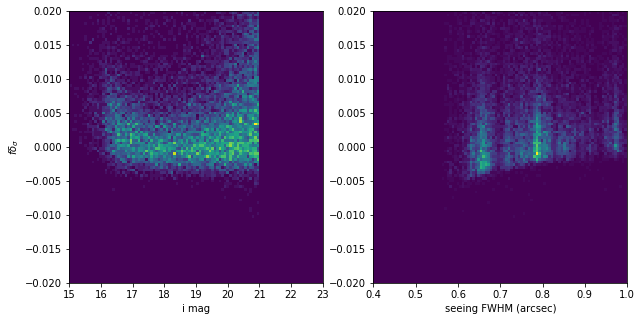

In [105]:
figure(figsize=(10,5))

subplot(121)
hist2d(data['mag_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[15,23],[-0.02,0.02]]);
xlabel('i mag')
ylabel('$f \delta_\sigma$')
subplot(122)
hist2d(data['psf_fwhm_i'], (data['sigma'] - data['psf_sigma'])/data['psf_sigma'], 100, range=[[0.4,1.0],[-0.02,0.02]]);
xlabel('seeing FWHM (arcsec)')

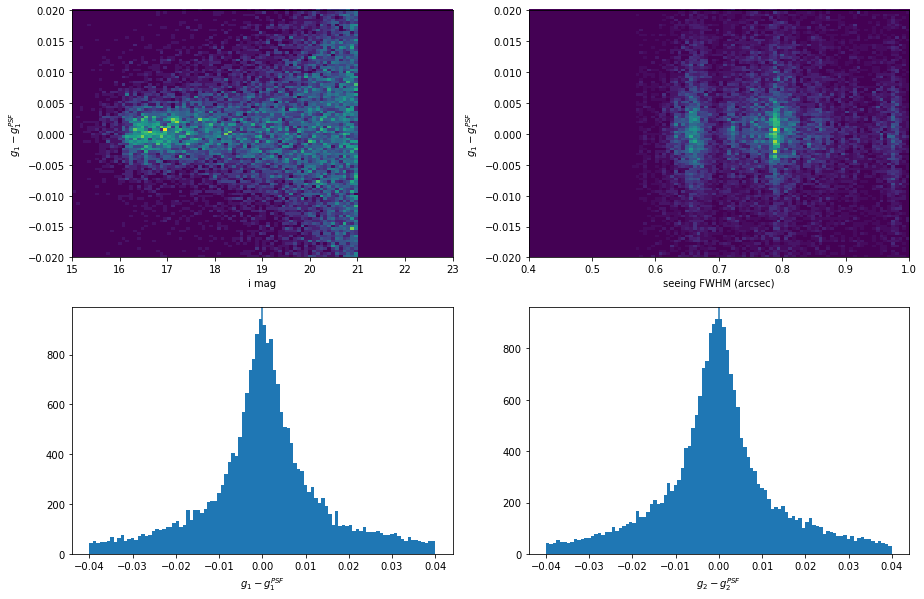

In [106]:
figure(figsize=(15,10))

subplot(221)
hist2d(data['mag_i'], (data['g1'] - data['psf_g1']), 100, range=[[15,23],[-0.02,0.02]]);
xlabel('i mag')
ylabel('$g_1 - g_1^{PSF}$')
subplot(222)
hist2d(data['psf_fwhm_i'], (data['g1'] - data['psf_g1']), 100, range=[[0.4,1.0],[-0.02,0.02]]);
xlabel('seeing FWHM (arcsec)')
ylabel('$g_1 - g_1^{PSF}$')

subplot(223)
hist((data['g1'] - data['psf_g1']), 100, range=[-0.04,0.04]);
xlabel('$g_1 - g_1^{PSF}$')
axvline(0)
subplot(224)
hist((data['g2'] - data['psf_g2']), 100, range=[-0.04,0.04]);
xlabel('$g_2 - g_2^{PSF}$')
axvline(0)

In [132]:
import pandas
import stile

d = pandas.DataFrame(data)
d['w'] =1
d = d.to_records(index=False)

In [133]:
stile_args = {'ra_units': 'degrees', 'dec_units': 'degrees',
              'min_sep': 0.05, 'max_sep': 1, 'sep_units': 'degrees', 'nbins': 20}

In [134]:
rho1 = stile.CorrelationFunctionSysTest('Rho1')
rho2 = stile.CorrelationFunctionSysTest('Rho2')

r1 = rho1(d, config=stile_args)
r2 = rho2(d, config=stile_args)

In [135]:
# Temporary fix
r1.dtype.names=('Rnom',
 'meanR',
 'meanlogR',
 'xip',
 'xim',
 'xip_im',
 'xim_im',
 'sigma_xi',
 'weight',
 'npairs')
r2.dtype.names=('Rnom',
 'meanR',
 'meanlogR',
 'xip',
 'xim',
 'xip_im',
 'xim_im',
 'sigma_xi',
 'weight',
 'npairs')

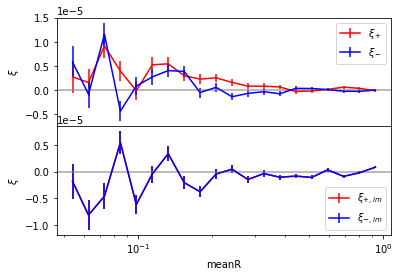

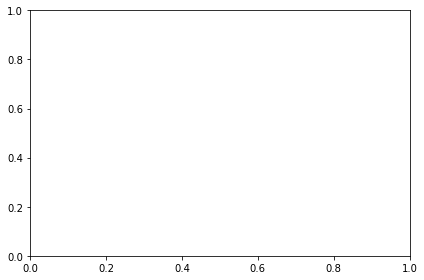

In [136]:
f = rho1.plot(r1);

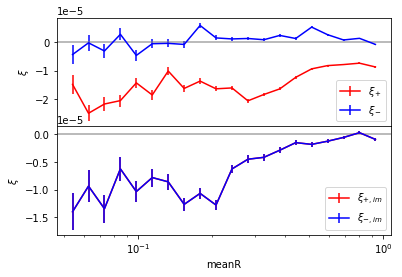

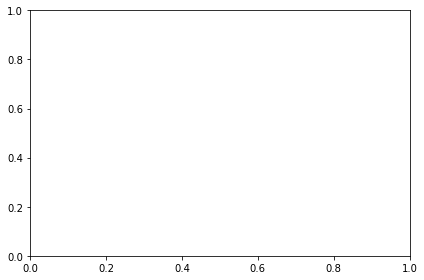

In [138]:
f = rho2.plot(r2);